# Проект "[SF] Car Price prediction Part2"

## Goal

Цель -  прогнозирование стоимости автомобиля по характеристикам, описанию и фотографии.

Соревнование kaggle - https://www.kaggle.com/c/sf-dst-car-price-prediction-part2

## Setup

### library import

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -Uq catboost
!pip install -Uq tensorflow_text
!pip install -Uq pymorphy2

     |████████████████████████████████| 76.4 MB 61 kB/s 
     |████████████████████████████████| 4.4 MB 8.4 MB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 8.2 MB 14.4 MB/s 


In [ ]:
import glob
import os
import shutil
import string
import subprocess
import sys
import zipfile
from collections import Counter
from datetime import datetime

import albumentations
import cv2
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import PIL
import pymorphy2
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as L
import tensorflow_hub as hub
import tensorflow_text as text
from catboost import CatBoostRegressor
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from tensorflow.keras import *
from tensorflow.keras import optimizers
from tensorflow.keras.applications import EfficientNetB6, Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import (Callback, EarlyStopping,
                                        LearningRateScheduler, ModelCheckpoint)
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.ops.gen_math_ops import mod

### setup

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

!pip freeze > requirements.txt

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

# kaggle
DATA_PATH_KAGGLE = '../input/sf-dst-car-price-prediction-part2'

# colab
DATA_PATH_COLAB = '/content/drive/MyDrive/module9/'

IS_ENV_COLAB = 'google.colab' in sys.modules

if IS_ENV_COLAB:
    DATA_PATH = DATA_PATH_COLAB
else:
    DATA_PATH = DATA_PATH_KAGGLE

MOCK_DATA = False

Python       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
Numpy        : 1.19.5
Tensorflow   : 2.6.0


## Data

### data description

Признаки:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

### load data

In [ ]:
def download_competition_data():
    """
    dowload data in colab from kaggle
    """
    DATASET = 'pavelmoskvitin/carprice2'

    subprocess.run(['mkdir', '-p', '/root/.kaggle'], capture_output=True)
    subprocess.run(
        ['cp',
         '/content/drive/MyDrive/module9/kaggle.json',
         '/root/.kaggle'],
        capture_output=True)

    if not DATASET in os.listdir('.'):
        subprocess.run(['kaggle', 'datasets', 'download',
                        DATASET], capture_output=True)


def unzip_data(path_input='./', path_output='/content/drive/MyDrive/module9'):
    # unzip data
    datafile = 'carprice2.zip'
    if not os.path.exists(path_output):
        os.makedirs(path_output)
    if not 'kaggle' in os.listdir(path_output):
        with zipfile.ZipFile(f'{path_input}{datafile}', 'r') as z:
            z.extractall(path_output)


def get_competition_data():
    if IS_ENV_COLAB:
        # running in colab
        download_competition_data()
        unzip_data()


def load_train_test_from_csv(path=DATA_PATH):
    """
    load DataFrames from files (train_df, sample_submission)
    """
    train_df = pd.read_csv(f'{path}train.csv')
    test_df = pd.read_csv(f'{path}test.csv')
    sample_submission = pd.read_csv(f'{path}sample_submission.csv')
    return (train_df, test_df, sample_submission)


def merge_train_test(train_df, test_df):
    train_df['sample'] = 1  # помечаем где у нас трейн
    test_df['sample'] = 0  # помечаем где у нас тест
    test_df['price'] = 0
    df = test_df.append(train_df, sort=False).reset_index(
        drop=True)  # объединяем
    # print(train_df.shape, test_df.shape, df.shape)
    return df


def get_split_train_test(df_preproc):
    train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
    test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

    y = train_data.price
    X = train_data.drop(['price'], axis=1)
    X_test = test_data.drop(['price'], axis=1)

    return X, y, X_test


def copy_to_gdrive(path):
    gdrive = '/content/drive/MyDrive/module9'
    for file in glob.glob(path):
        shutil.copy2(file, gdrive)


def copy_from_gdrive(path):
    gdrive = '/content/drive/MyDrive/module9'
    from_path = gdrive + path
    for file in glob.glob(from_path):
        shutil.copy2(file, '.')

Для работы в Colab необходим подключенный GDrive и файл `content/drive/MyDrive/Colab Notebooks/kaggle/kaggle.json`

In [ ]:
# download competition data for colab
get_competition_data()
# load data from files
(train_df, test_df, sample_submission) = load_train_test_from_csv()


In [ ]:
if MOCK_DATA:
    train_df = train_df[:100]

In [ ]:
df = merge_train_test(train_df, test_df)

## EDA

### tabular data

In [ ]:
train_df.sample(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample
2854,внедорожник 5 дв.,BMW,чёрный,Автомобиль в отличном состоянии.\nБез дтп. \nД...,3.0 LTR,306 N12,дизель,165700,2010,X5,40d 3.0d AT (306 л.с.) 4WD,5,1355000.0,2011,1099943336,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1
5046,седан,BMW,чёрный,В хорошем состоянии много всего заменено.подро...,2.2 LTR,170 N12,бензин,300000,2001,3ER,320i 2.2 MT (170 л.с.),4,380000.0,2003,1100106392,SEDAN MECHANICAL 2.2,механическая,3 или более,8 лет и 3 месяца,Дубликат,задний,Левый,1
6040,лифтбек,AUDI,белый,Салон: 8. Безопасность: 10. Комфорт: 12. Мульт...,2.0 LTR,230 N12,бензин,78187,2011,A5,2.0 AMT (230 л.с.) 4WD,5,1500000.0,2015,1096135676,LIFTBACK ROBOT 2.0,роботизированная,2 владельца,2 года и 9 месяцев,Оригинал,полный,Левый,1
3499,седан,MERCEDES,белый,"Возможна продажа с НДС\nЯ второй владелец, обс...",2.0 LTR,184 N12,бензин,72000,2016,E_KLASSE,200 2.0 AT (184 л.с.),4,2250000.0,2016,1099533554,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,2 года и 3 месяца,Оригинал,задний,Левый,1
5624,седан,AUDI,белый,Безопасность: 7. Обзор: 3. Комфорт: 5. Салон: ...,1.4 LTR,150 N12,бензин,111625,2015,A4,1.4 AMT (150 л.с.),4,1223000.0,2016,1099606912,SEDAN ROBOT 1.4,роботизированная,1 владелец,NaN,Оригинал,передний,Левый,1


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [ ]:
train_df.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
sample                     1
dtype: int64

In [ ]:
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize=(columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins=20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width=(bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

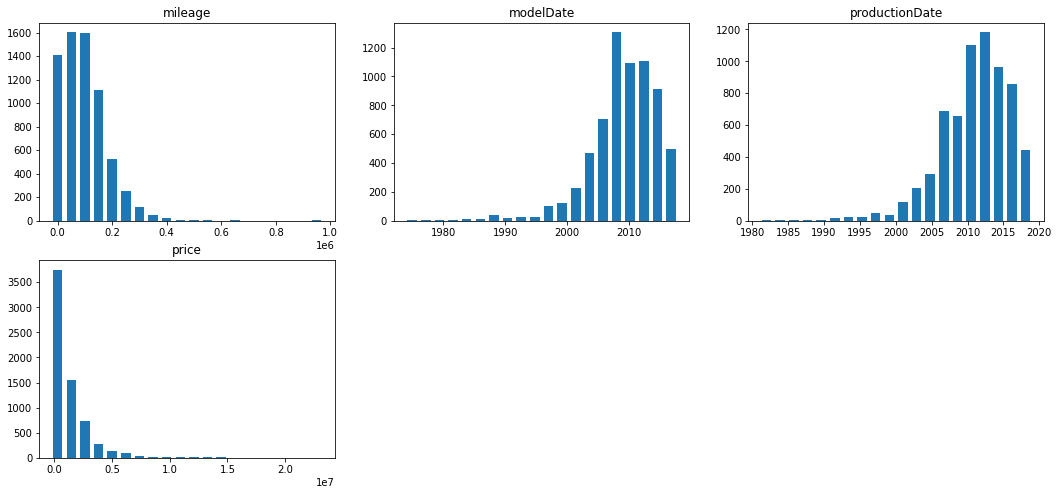

In [ ]:
visualize_distributions({
    'mileage': train_df['mileage'].dropna(),
    'modelDate': train_df['modelDate'].dropna(),
    'productionDate': train_df['productionDate'].dropna(),
    'price': train_df['price'].dropna()

})


Возможно, понадобится логарифмирование чилословых показателей.

### image samples

In [ ]:
def view_sample_images():
    plt.figure(figsize=(12, 8))

    random_image = train_df.sample(n=9)
    random_image_paths = random_image['sell_id'].values
    random_image_cat = random_image['price'].values

    for index, path in enumerate(random_image_paths):
        im = PIL.Image.open(DATA_PATH+'img/img/' + str(path) + '.jpg')
        plt.subplot(3, 3, index + 1)
        plt.imshow(im)
        plt.title('price: ' + str(random_image_cat[index]))
        plt.axis('off')
    plt.show()


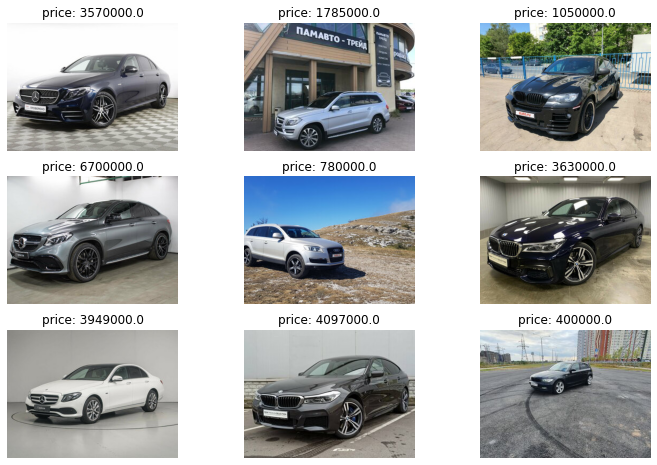

In [ ]:
view_sample_images()

### image resolutions

In [ ]:
def get_images_size(df: pd.DataFrame):
    sizes = [cv2.imread(DATA_PATH + 'img/img/' + str(id) +
                        '.jpg').shape for id in df['sell_id']]
    counter = Counter(sizes)
    return counter

In [ ]:
images_size = get_images_size(df)
pd.DataFrame({"resolution": images_size.keys(),
              "count": images_size.values()})

,resolution,count
0,"(240, 320, 3)",8350
1,"(120, 160, 3)",1
2,"(224, 320, 3)",1
3,"(240, 240, 3)",1


Почти все изображения имеют разрешение 240x320 c 3 каналами.

## Models

### baseline
Эта модель будет предсказывать среднюю цену по модели и году выпуска.

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def median_predict(train):
    """
    Создадим "наивную" модель
    Эта модель будет предсказывать среднюю цену по модели и году выпуска.
    C ней будем сравнивать другие модели.
    """

    # split данных
    data_train, data_test = train_test_split(
        train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

    # Наивная модель
    predicts = []
    for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
        query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
        predicts.append(data_train.query(query)['price'].median())

    # заполним не найденные совпадения
    predicts = pd.DataFrame(predicts)
    predicts = predicts.fillna(predicts.median())

    predicts = (predicts // 1000) * 1000

    # оцениваем точность
    print(
        f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")
    # print(f"Validation mape: {val_mape: 0.2f} %")

median_predict(train_df)


Точность наивной модели по метрике MAPE: 19.88%


### CatBoostRegressor

#### baseline data

In [ ]:
def get_validation(model, X, is_model_neuron=False):
    val_predict = model.predict(X)
    y_val_copy = y_val
    if is_model_neuron:
        val_predict = val_predict[:, 0]
    if LOG_TARGET:
        val_predict = np.expm1(val_predict)
        y_val_copy = np.expm1(y_val_copy)

    val_mape = mape(y_val_copy, val_predict)*100
    print(f"Validation mape: {val_mape: 0.2f} %")
    return val_predict


def get_submission(model, X=[], name='name', is_model_neuron=False):
    submission = sample_submission.copy()
    if MAKE_SUBMISSION:
        sub_predict = model.predict(X)
        if is_model_neuron:
            sub_predict = sub_predict[:, 0]
        if LOG_TARGET:
            sub_predict = np.expm1(sub_predict)
        submission['price'] = sub_predict
        submission.to_csv(f'{name}_submission.csv', index=False)
    return submission['price']


def get_fit_catboost():
    model = CatBoostRegressor(iterations=20000,
                              # depth=10,
                              # learning_rate = 0.5,
                              random_seed=RANDOM_SEED,
                              eval_metric='MAPE',
                              custom_metric=['RMSE', 'MAE'],
                              od_wait=500,
                              # task_type='GPU',
                              )
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              verbose_eval=1000,
              use_best_model=True,
              # plot=True
              )

    return model


def run_catboost():
    model = get_fit_catboost()
    val_catboost = get_validation(model, X=X_val, is_model_neuron=False)
    submission_catboost = get_submission(
        model, X=X_test, name='catboost', is_model_neuron=False)
    return val_catboost, submission_catboost


In [ ]:
def preproc_data_base(df_input):
    '''includes several functions to pre-process the predictor data.'''
    categorical_features = ['bodyType', 'brand', 'color',
                            'engineDisplacement', 'enginePower',
                            'fuelType', 'model_info', 'name',
                            'numberOfDoors', 'vehicleTransmission', 'Владельцы',
                            'Владение', 'ПТС', 'Привод', 'Руль']
    numerical_features = ['mileage', 'modelDate', 'productionDate']

    df_output = df_input.copy()

    # ################### 1. Предобработка ##############################################################
    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id', ], axis=1, inplace=True)

    # ################### Numerical Features ##############################################################
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # ################### Categorical Features ##############################################################
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(
        df_output, columns=categorical_features, dummy_na=False)

    # ################### Clean ####################################################
    df_output.drop(['vehicleConfiguration'], axis=1, inplace=True)

    return df_output


In [ ]:
LOG_TARGET = False
MAKE_SUBMISSION = True
SAVE_MODEL = False


df_preproc_base = preproc_data_base(df)
(X, y, X_test) = get_split_train_test(df_preproc_base)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

val_catboost, submission_catboost = run_catboost()


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.010757
0:	learn: 0.9963519	test: 1.0206790	best: 1.0206790 (0)	total: 5.53ms	remaining: 1m 50s
1000:	learn: 0.2169695	test: 0.2235179	best: 0.2235179 (1000)	total: 4.82s	remaining: 1m 31s
2000:	learn: 0.1787718	test: 0.1877364	best: 0.1877364 (2000)	total: 9.65s	remaining: 1m 26s
3000:	learn: 0.1572792	test: 0.1666756	best: 0.1666756 (3000)	total: 14.5s	remaining: 1m 22s
4000:	learn: 0.1456056	test: 0.1568951	best: 0.1568951 (4000)	total: 19.3s	remaining: 1m 16s
5000:	learn: 0.1371458	test: 0.1508309	best: 0.1508309 (5000)	total: 24s	remaining: 1m 12s
6000:	learn: 0.1290674	test: 0.1448814	best: 0.1448814 (6000)	total: 28.8s	remaining: 1m 7s
7000:	learn: 0.1230743	test: 0.1409097	best: 0.1409097 (7000)	total: 33.6s	remaining: 1m 2s
8000:	learn: 0.1171389	test: 0.1372497	best: 0.1372497 (8000)	total: 38.5s	remaining: 57.7s
9000:	learn: 0.1129743	test: 0.1352719	best: 0.1352719 (9000)	total: 43.2s	remaining: 52.8s
10000:	learn: 0.1093592	test: 0.1336058	best: 0.133

#### add data preprocessing

In [ ]:
def preproc_data_catboost(df_input, n_key_words=150):
    '''includes several functions to pre-process the predictor data.'''
    categorical_features = ['bodyType', 'brand', 'color',
                            'fuelType', 'model_info',
                            'numberOfDoors', 'vehicleTransmission',
                            'ПТС', 'Привод', 'Руль']
    # rank_features = ['number_owners']
    numerical_features = ['mileage', 'modelAge', 'productionDate',
                          'engineDisplacement', 'enginePower']
    columns_to_clean = ['vehicleConfiguration',
                        'Владельцы',
                        'Владение',
                        'name',
                        'modelDate']

    def string_to_float(a):
        try:
            return float(a)
        except ValueError:
            # print(f"Error string to float: {a}")
            return None

    df = df_input.copy()

    # ################### 1. Предобработка ##############################################################
    df.drop(['description', 'sell_id', ], axis=1, inplace=True)

    df['number_owners'] = df['Владельцы'].fillna(
        '3').apply(lambda x: int(str.split(x)[0]))

    df['enginePower'] = df['enginePower'].apply(
        lambda x: int(str.split(x)[0]))

    df['engineDisplacement'] = df['engineDisplacement'].apply(
        lambda x: str.split(x)[0])
    df['engineDisplacement'] = df['engineDisplacement'].apply(
        string_to_float)

    df['modelAge'] = 2020 - df['modelDate']

    years = df['Владение'].str.extract(
        '(\d*) (го|ле)')[0].fillna(0).astype(int)
    months = df['Владение'].str.extract('(\d*) (ме)')[0].fillna(0).astype(int)
    df['months_ownership'] = years * 12 + months

    # ################### Numerical Features ##############################################################
    # Далее заполняем пропуски
    for column in numerical_features:
        if any(df[column].isna()):
            # print(f"{column} had NaN" )
            df[column].fillna(df[column].median(), inplace=True)

    # months_ownership fill with 'modelAge'
    df.loc[df['months_ownership'] == 0,
           'months_ownership'] = df.loc[df['months_ownership'] == 0, 'modelAge'] * 12

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df[column] = df[column].apply(np.log1p)
        df[column] = scaler.fit_transform(df[[column]])[:, 0]

    # ################### Target ####################################################
    if LOG_TARGET:
        df['price'] = df['price'].apply(np.log1p)

    # ################### Categorical Features ##############################################################
    # Label Encoding
    for column in categorical_features:
        # add mean price columns
        cat_price_dict = df.groupby(column)['price'].mean().to_dict()
        df[f"{column}_mean_price"] = df[column].apply(cat_price_dict.get)

        df[column] = df[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df = pd.get_dummies(
        df, columns=categorical_features, dummy_na=False)

    # One-Hot Encoding for key words in 'name'
    df['name'] = df['name'].str.replace(
        'AT|MT|AMT|\d\.\d[\w]*|\(.*\)', '').str.split()
    names_key_words = pd.Series(df['name'].sum()).value_counts()[:n_key_words]
    for name in names_key_words.index:
        df[f'name_{name}'] = df['name'].apply(
            lambda x: 1 if name in x else 0)

    # ################### Clean ####################################################
    df.drop(columns_to_clean, axis=1, inplace=True)
    print(f"Lenght: {len(df_input)} {len(df)}")
    return df

In [ ]:
LOG_TARGET = True

df_preproc_catboost = preproc_data_catboost(df)
(X, y, X_test) = get_split_train_test(df_preproc_catboost)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

val_catboost, submission_catboost = run_catboost()


Lenght: 8353 8353
Learning rate set to 0.010757
0:	learn: 0.0422906	test: 0.0423616	best: 0.0423616 (0)	total: 3.6ms	remaining: 1m 12s
1000:	learn: 0.0091380	test: 0.0090775	best: 0.0090765 (996)	total: 3.01s	remaining: 57.1s
2000:	learn: 0.0078873	test: 0.0082653	best: 0.0082653 (2000)	total: 6s	remaining: 54s
3000:	learn: 0.0072990	test: 0.0079961	best: 0.0079961 (3000)	total: 8.93s	remaining: 50.6s
4000:	learn: 0.0068951	test: 0.0078532	best: 0.0078531 (3997)	total: 11.9s	remaining: 47.5s
5000:	learn: 0.0065457	test: 0.0077544	best: 0.0077539 (4999)	total: 14.9s	remaining: 44.6s
6000:	learn: 0.0062334	test: 0.0076975	best: 0.0076975 (5999)	total: 17.9s	remaining: 41.8s
7000:	learn: 0.0059875	test: 0.0076570	best: 0.0076570 (7000)	total: 20.9s	remaining: 38.8s
8000:	learn: 0.0057726	test: 0.0076252	best: 0.0076252 (7999)	total: 23.9s	remaining: 35.9s
9000:	learn: 0.0055698	test: 0.0076031	best: 0.0076030 (8947)	total: 26.9s	remaining: 32.9s
10000:	learn: 0.0053767	test: 0.0075903	bes

После добавления новых числовых параметров, логарифмирования параметров и целевой переменной MAPE уменьшился.

### MLP with tabular data

#### baseline data

In [ ]:
def plot_history(history, model_name='model'):
    plt.figure(figsize=(10, 5))
    loss = history.history['MAPE']
    val_loss = history.history['val_MAPE']

    epochs = range(len(loss))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Loss {model_name}')
    plt.legend()
    # plt.savefig(f'loss_{model_name}_{now}.png', dpi=600)

    plt.show()


def create_callbacks(patience=50, lr=0.01, n=250):
    
    def lr_manual_nlp(epoch, lr_input):
        lr = lr_input
        if epoch >= n:
            lr = 0.001
        return lr

    checkpoint = ModelCheckpoint('best_model.hdf5',
                                 monitor=['val_MAPE'],
                                 verbose=1, mode='min')
    earlystop = EarlyStopping(monitor='val_MAPE',
                              patience=50,
                              restore_best_weights=True)

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
        lr_manual_nlp, verbose=1)

    callbacks_list = [
        checkpoint,
        earlystop,
        lr_scheduler
    ]
    return callbacks_list


def compile_model(model, lr=1e-3):
    '''
    Compile model
    '''
    model.compile(loss="MAPE",
                  optimizer=optimizers.Adam(lr),
                  metrics=["MAPE"])

In [ ]:
def dense_model():
    """
    simple dense model for tabular
    """
    model = Sequential(name='Simple_dense')
    model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(256, activation="relu"))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(1, activation="linear"))

    model.summary()
    return model


def run_dense():
    # Dense model
    model = dense_model()
    compile_model(model, lr=1e-2)
    callbacks_list = create_callbacks()

    history = model.fit(X_train, y_train,
                        batch_size=512,
                        epochs=350,
                        validation_data=(X_val, y_val),
                        callbacks=callbacks_list,
                        verbose=1,
                        )
    plot_history(history, model_name=model.name)

    model.load_weights('best_model.hdf5')
    if SAVE_MODEL:
        model.save(f'{model.name}.hdf5')

    val_nn1 = get_validation(model, X=X_val, is_model_neuron=True)
    submission_nn1 = get_submission(model, X=X_test, name=model.name,
                                    is_model_neuron=True)

    return val_nn1, submission_nn1

Model: "Simple_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               790528    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 922,113
Trainable params: 922,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/350

Epoch 00001: LearningRateScheduler setting learning rate to 0.009999999776482582.
12/12 [============

<Figure size 720x360 with 0 Axes>

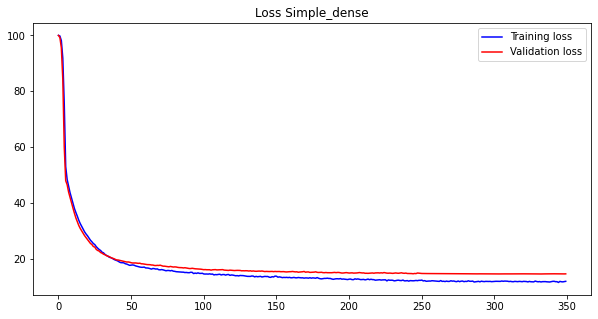

Validation mape:  14.64 %


In [ ]:
LOG_TARGET = False

(X, y, X_test) = get_split_train_test(df_preproc_base)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

val_nn_dense_base, submission_nn_dense_base = run_dense()

#### add data preprocessing

In [ ]:
def preproc_data_dense(df_input, n_key_words=30):
    '''includes several functions to pre-process the predictor data.'''
    categorical_features = ['bodyType', 'brand', 'color',
                            'fuelType', 'model_info',
                            'numberOfDoors', 'vehicleTransmission',
                            'ПТС', 'Привод', 'Руль',
                            ]
    # rank_features = ['number_owners']
    numerical_features = ['mileage',
                          'modelAge',
                          'months_ownership',
                          'productionDate',
                          'engineDisplacement', 'enginePower']
    columns_to_clean = ['vehicleConfiguration',
                        'Владельцы',
                        'Владение',
                        'name',
                        'modelDate']

    def string_to_float(a):
        try:
            return float(a)
        except ValueError:
            # print(f"Error string to float: {a}")
            return None

    df = df_input.copy()

    # ################### 1. Предобработка ##############################################################
    # убираем не нужные для модели признаки
    df.drop(['description', 'sell_id', ], axis=1, inplace=True)

    df['number_owners'] = df['Владельцы'].fillna(
        '3').apply(lambda x: int(str.split(x)[0]))

    df['enginePower'] = df['enginePower'].apply(
        lambda x: int(str.split(x)[0]))

    df['engineDisplacement'] = df['engineDisplacement'].apply(
        lambda x: str.split(x)[0])
    df['engineDisplacement'] = df['engineDisplacement'].apply(
        string_to_float)

    df['modelAge'] = 2020 - df['modelDate']

    years = df['Владение'].str.extract(
        '(\d*) (го|ле)')[0].fillna(0).astype(int)
    months = df['Владение'].str.extract('(\d*) (ме)')[0].fillna(0).astype(int)
    df['months_ownership'] = years * 12 + months

    # ################### Numerical Features ##############################################################
    # Далее заполняем пропуски
    for column in numerical_features:
        if any(df[column].isna()):
            # print(f"{column} had NaN" )
            df[column].fillna(df[column].median(), inplace=True)
    # тут ваш код по обработке NAN

    # months_ownership fill with 'modelAge'
    df.loc[df['months_ownership'] == 0,
           'months_ownership'] = df.loc[df['months_ownership'] == 0, 'modelAge'] * 12
    # months_ownership fill with 'months_ownership' mean
    # df.loc[df['months_ownership'] == 0, 'months_ownership'] = np.nan
    # df['months_ownership'].fillna(df['months_ownership'].mean(), inplace=True)

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df[column] = df[column].apply(np.log1p)
        df[column] = scaler.fit_transform(df[[column]])[:, 0]

    # PolynomialFeatures
    poynom_f = PolynomialFeatures(degree=5, include_bias=False)
    arr = poynom_f.fit_transform(df[numerical_features])
    cols = poynom_f.get_feature_names(numerical_features)
    df_poly = pd.DataFrame(arr, columns=cols).drop(columns=numerical_features)
    df = df.merge(df_poly, left_index=True, right_index=True)
    # print('shape preproc_data_dense ', df.shape, df_poly.shape)

    # ################### Target ####################################################
    if LOG_TARGET:
        df['price'] = df['price'].apply(np.log1p)

    # ################### Categorical Features ##############################################################
    # Label Encoding
    for column in categorical_features:
        # add mean price columns
        # cat_price_dict = df.groupby(column)['price'].mean().to_dict()
        # df[f"{column}_mean_price"] = df[column].apply(cat_price_dict.get)

        df[column] = df[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df = pd.get_dummies(
        df, columns=categorical_features, dummy_na=False)

    # One-Hot Encoding for key words in 'name'
    df['name'] = df['name'].str.replace(
        'AT|MT|AMT|\d\.\d[\w]*|\(.*\)', '').str.split()
    names_key_words = pd.Series(df['name'].sum()).value_counts()[:n_key_words]
    for name in names_key_words.index:
        df[f'name_{name}'] = df['name'].apply(
            lambda x: 1 if name in x else 0)

    # ################### Clean ####################################################
    df.drop(columns_to_clean, axis=1, inplace=True)
    print(f"Lenght: {len(df_input)} {len(df)}")
    return df

Lenght: 8353 8353
Model: "Simple_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               343040    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 474,625
Trainable params: 474,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/350

Epoch 00001: LearningRateScheduler setting learning rate to 0.009999999776482582.
1

<Figure size 720x360 with 0 Axes>

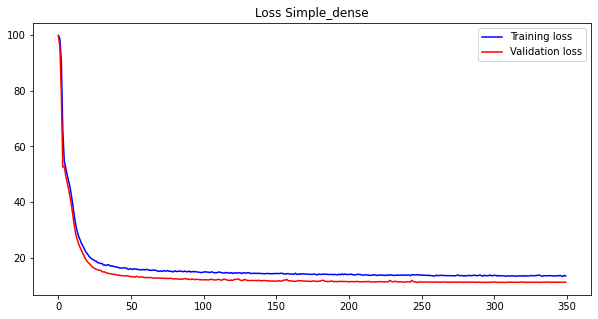

Validation mape:  11.14 %


In [ ]:
df_preproc = preproc_data_dense(df, 30)
(X, y, X_test) = get_split_train_test(df_preproc)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

val_nn_dense, submission_nn_dense = run_dense()


Значения MAPE снизилось. 

#### remove target outliers

In [ ]:

def  drop_target_outliers(x_input, y_input):
    y = y_input.copy()
    q_hi = y.quantile(0.99)
    y = y[y < q_hi]
    x = x_input.loc[y.index]
    print('shape outliers ', x_input.shape, x.shape, y.shape)
    return x, y

shape outliers  (5622, 669) (5565, 669) (5565,)
Model: "Simple_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               343040    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 474,625
Trainable params: 474,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/350

Epoch 00001: LearningRateScheduler setting learning r

<Figure size 720x360 with 0 Axes>

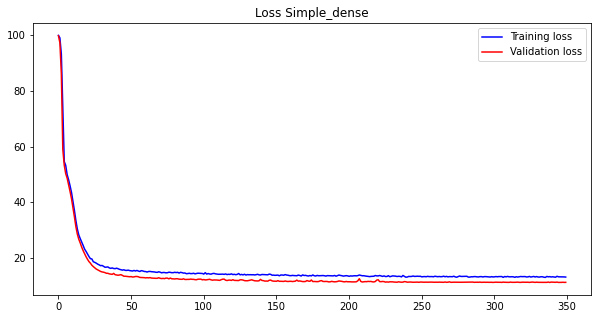

Validation mape:  11.20 %


In [ ]:
X_train, y_train = drop_target_outliers(X_train, y_train)

val_nn_dense, submission_nn_dense = run_dense()

Значительных изменений не произошло.

### NLP + Tabular. Multiple Input NN

#### RNN NLP
Multiple input:
* rnn nlp
* tabular mlp

In [ ]:
def nlp_bi_multi_input_model(input_shape, emb_input_dim, emb_output_dim):
    # RNN NLP
    model_nlp = Sequential(name="rnn_nlp")
    model_nlp.add(L.InputLayer(
        input_shape=input_shape, name="seq_description"))
    model_nlp.add(L.Embedding(emb_input_dim, emb_output_dim))
    model_nlp.add(L.Bidirectional(L.LSTM(256, return_sequences=True)))
    model_nlp.add(L.Dropout(0.5))
    model_nlp.add(L.Bidirectional(L.LSTM(128)))
    model_nlp.add(L.Dropout(0.25))
    model_nlp.add(L.Dense(64, activation="relu"))
    model_nlp.add(L.Dropout(0.25))

    # MLP
    model_mlp = Sequential(name="mlp_tab")
    model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
    model_mlp.add(L.Dropout(0.5))
    model_mlp.add(L.Dense(256, activation="relu"))
    model_mlp.add(L.Dropout(0.5))

    # Multiple Inputs NN
    combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
    head = L.Dense(64, activation="relu")(combinedInput)
    head = L.Dense(1, activation="linear")(head)

    model = Model(inputs=[model_nlp.input, model_mlp.input],
                  outputs=head, name='NLP_Multiple_Inputs')

    model.summary()
    return model


def run_nlp_multi_input():
    # TOKENIZER
    # The maximum number of words to be used. (most frequent)
    MAX_WORDS = 100000
    # Max number of words in each complaint.
    MAX_SEQUENCE_LENGTH = 256

    # split данных
    text_train = description.iloc[X_train.index]
    text_val = description.iloc[X_val.index]
    text_test = description.iloc[X_test.index]

    # Tokenizer
    tokenize = Tokenizer(num_words=MAX_WORDS)
    tokenize.fit_on_texts(description)

    # tokenize.word_index

    text_train_sequences = sequence.pad_sequences(
        tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
    text_val_sequences = sequence.pad_sequences(
        tokenize.texts_to_sequences(text_val), maxlen=MAX_SEQUENCE_LENGTH)
    text_test_sequences = sequence.pad_sequences(
        tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)

    model = nlp_bi_multi_input_model(
        input_shape=MAX_SEQUENCE_LENGTH,
        emb_input_dim=len(tokenize.word_index)+1, emb_output_dim=MAX_SEQUENCE_LENGTH)

    """### Fit"""

    compile_model(model, lr=1e-2)
    callbacks_list = create_callbacks(patience=10)

    history = model.fit([text_train_sequences, X_train], y_train,
                        batch_size=512,
                        epochs=150,
                        validation_data=([text_val_sequences, X_val], y_val),
                        callbacks=callbacks_list
                        )

    plot_history(history, model_name=model.name)

    model.load_weights('best_model.hdf5')
    if SAVE_MODEL:
        model.save(f'{model.name}.hdf5')

    val_predict_nn2 = get_validation(model, X=[text_val_sequences, X_val],
                                     is_model_neuron=True)
    submission_nn2 = get_submission(model,
                                    X=[text_test_sequences, X_test],
                                    name=model.name,
                                    is_model_neuron=True)
    return val_predict_nn2, submission_nn2


Model: "NLP_Multiple_Inputs"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256, 512)     1050624     embedding[0][0]                  
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 512)     0           bidirectional[0][0]              
________________________________________________________________________________

<Figure size 720x360 with 0 Axes>

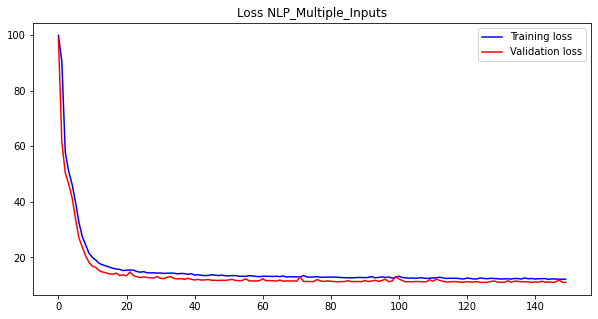

Validation mape:  11.02 %


In [ ]:
(X, y, X_test) = get_split_train_test(df_preproc)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

description = df['description']

val_nn_rnn, submission_nn_rnn = run_nlp_multi_input()


Наблюдается снижение MAPE.

#### RNN NLP with text preprocessing
Multiple input:
* rnn nlp
* tabular mlp

In [ ]:
def preproc_text_data(text_input: pd.Series) -> pd.Series:
    text_out = text_input.copy()

    # Replace dealer deicription to dealer name
    text_out = replace_brands(text_out)

    # drop punctuation
    # text_out = text.str.replace('[{}\n\d]'.format(string.punctuation), ' ')
    text_out = text_out.str.replace(
        '[{}\n\d\W]'.format(string.punctuation), ' ')
    # to lowercase
    text_out = text_out.str.lower()

    # tokenize
    nltk.download('punkt')
    text_out = text_out.apply(nltk.word_tokenize)
    # drop stopwords
    nltk.download('stopwords')
    ru_stopwords = stopwords.words('russian')
    stop_words = ru_stopwords
    # stop_words = ru_stopwords + stop_words_manual
    text_out = text_out.apply(
        lambda x: [s for s in x if s not in stop_words])

    # word to normal form
    morph = pymorphy2.MorphAnalyzer()
    text_out = text_out.apply(
        lambda x: [morph.normal_forms(word)[0] for word in x])

    # stem words
    # stemmer = SnowballStemmer("russian")
    # text_out = text_out.apply(lambda x: [stemmer.stem(s) for s in x])

    text_out = text_out.apply(lambda x: ' '.join(x))

    return text_out


def replace_brands(description: pd.Series) -> pd.Series:
    stop_brends = ['rolf', 'AVILON', 'Группа Компаний БИЗНЕС КАР',
                   'Inchcape Certified', 'ABTODOM', 'АВТОДОМ',
                   'Мерседес-Бенц РУС', 'Панавто', 'Trade']

    def replace_text(description_input, stop_brends):
        description_out = description_input.copy()
        for stop in stop_brends:
            filter = description_out.str.contains(stop)
            description_out.loc[filter] = f"replaced{stop.replace(' ', '')}"
        return description_out

    return replace_text(description, stop_brends)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Model: "NLP_Multiple_Inputs"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 256)     4299264     seq_description[0][0]            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 256, 512)     1050624     embedding_1[0][0]                
_____________________________________________________________

<Figure size 720x360 with 0 Axes>

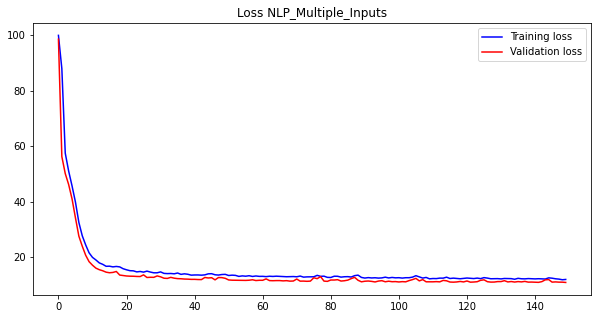

Validation mape:  10.92 %


In [ ]:
description = df['description']
description = preproc_text_data(description)

val_nn_rnn, submission_nn_rnn = run_nlp_multi_input()

#### NLP with LaBSE text embedding
Multiple input:
* NLP with LaBSE text embedding
* tabular mlp

Так как у нас мало даннных для тренировки на текстовых данных, то заменим NLP часть на эмбеддинг предобученной модели LsBSE (https://tfhub.dev/google/LaBSE/2).

In [ ]:
def get_LaBSE_emb(description: pd.Series) -> pd.DataFrame:
    """
    return np.array shape (, 768) LaBSE embeddings
    """

    preprocessor = hub.KerasLayer(
        "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
    encoder = hub.KerasLayer("https://tfhub.dev/google/LaBSE/2")

    n = len(description)
    k = 100  # batch sise
    embed = np.empty((n, 768))
    embed.fill(0)

    # iterate over data with k batch
    for i in range(n//k + (n % k > 0)):
        # print(f"{i*k}:{i*k+k} of 0:{n} \r")
        embed[i*k:i*k+k,
              :] = encoder(preprocessor(description[i*k:i*k+k])
                           )['default'].numpy()

    return pd.DataFrame(embed)


def nlp_LaBSE_emb_multi_input_model():
    DROP_OUT = 0.5

    # NLP
    input_nlp = tf.keras.layers.Input(shape=768)
    model_nlp = L.Dense(256, activation="relu", name='nlp')(input_nlp)
    model_nlp = L.Dropout(DROP_OUT)(model_nlp)

    # MLP
    model_mlp = Sequential(name="mlp_tab")
    model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
    model_mlp.add(L.Dropout(DROP_OUT))
    model_mlp.add(L.Dense(256, activation="relu"))
    model_mlp.add(L.Dropout(DROP_OUT))

    # Multiple Inputs NN
    combinedInput = L.concatenate([model_nlp, model_mlp.output])
    head = L.Dense(64, activation="relu")(combinedInput)
    head = L.Dense(1, activation="linear")(head)

    model = Model(inputs=[input_nlp, model_mlp.input],
                  outputs=head, name='NLP_emb_Multiple_Inputs')

    # model.summary()
    return model


def run_LaBSE_emb_multi():

    # split данных
    text_train = description.iloc[X_train.index]
    text_val = description.iloc[X_val.index]
    text_test = description.iloc[X_test.index]

    model = nlp_LaBSE_emb_multi_input_model()

    """### Fit"""

    compile_model(model, lr=1e-2)
    callbacks_list = create_callbacks(patience=10)

    print(model.summary())

    history = model.fit([text_train, X_train],
                        y_train,
                        batch_size=512,
                        epochs=1000,
                        validation_data=([text_val, X_val], y_val),
                        callbacks=callbacks_list
                        )

    plot_history(history, model_name=model.name)

    model.load_weights('best_model.hdf5')
    if SAVE_MODEL:
        model.save(f'{model.name}.hdf5')

    val_predict_nn2 = get_validation(model, X=[text_val, X_val],
                                     is_model_neuron=True)
    submission_nn2 = get_submission(model,
                                    X=[text_test, X_test],
                                    name=model.name,
                                    is_model_neuron=True)

    return val_predict_nn2, submission_nn2

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Model: "NLP_emb_Multiple_Inputs"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_49_input (InputLayer)     [(None, 669)]        0                                            
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 512)          343040      dense_49_input[0][0]             
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 768)]        0                                            
____________________________________________

<Figure size 720x360 with 0 Axes>

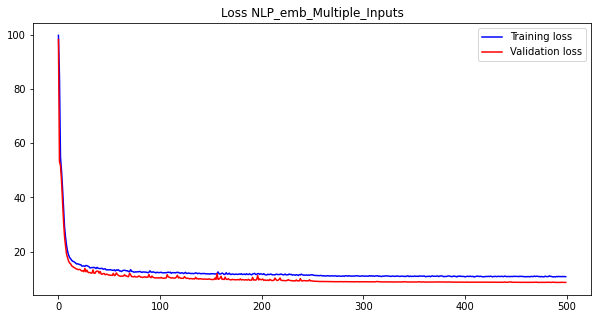

Validation mape:  8.64 %


In [ ]:
description = df['description']
description = preproc_text_data(description)
description = get_LaBSE_emb(description)

val_predict_nlp_emb, submission_nlp_emb = run_LaBSE_emb_multi()

MAPE снизился, качество предсказаний улучшилось.

### NLP + images + Tabular. Multiple Input NN

Так как у нас мало данных для тренировки на изображениях, то будем использовать эмбеддинги уже имеющихся предобученных сетей: efficientnet_v2 (https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2) и inception_resnet_v2 (https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5). Для текста продолжим использовать эмбеддинг LaBSE (https://tfhub.dev/google/LaBSE/2).

#### efficientnet_v2 image embedding
Multiple input:
* efficientnet_v2 image embedding,
* LaBSE text embedding,
* tabular mlp

In [ ]:
def get_img_emb(sell_id: pd.Series, size=(240, 240)) -> np.array:
    """
    return np.array shape (, 1280) efficientnet_v2_imagenet1k_b1 embeddings
    """
    def to_image(sell_id):
        image = cv2.imread(DATA_PATH + 'img/img/' + str(sell_id) + '.jpg')
        image = cv2.resize(image, size)
        image = image / 255
        return image

    n = len(sell_id)
    k = 100  # batch sise
    embed = np.empty((n, emb_size))
    embed.fill(0)

    # iterate over data with k batch
    for i in range(n//k + (n % k > 0)):
        # print(f"{i*k}:{i*k+k} of 0:{n} \r")
        images = np.array([to_image(id) for id in sell_id[i*k:i*k+k].values])
        embed[i*k:i*k+k, :] = encoder(images).numpy()

    return embed

In [ ]:
def nlp_img_emb_multi_input_model(input_img_shape=1280):
    DROP_OUT = 0.5

    # Image
    input_img = tf.keras.layers.Input(shape=input_img_shape)
    model_img = input_img
    # model_img = L.Dense(32, activation="relu", name='img')(input_img)
    model_img = L.Dropout(DROP_OUT)(model_img)

    # NLP
    input_nlp = tf.keras.layers.Input(shape=768)
    model_nlp = L.Dense(256, activation="relu", name='nlp')(input_nlp)
    model_nlp = L.Dropout(DROP_OUT)(model_nlp)

    # MLP
    model_mlp = Sequential(name="mlp_tab")
    model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
    model_mlp.add(L.Dropout(DROP_OUT))
    model_mlp.add(L.Dense(256, activation="relu"))
    model_mlp.add(L.Dropout(DROP_OUT))

    # Multiple Inputs NN
    combinedInput = L.concatenate([model_img, model_nlp, model_mlp.output])
    head = L.Dense(64, activation="relu")(combinedInput)
    head = L.Dense(1, activation="linear")(head)

    model = Model(inputs=[input_img, input_nlp, model_mlp.input],
                  outputs=head, name='Img_Emb_Multiple_Inputs')

    # model.summary()
    return model


def run_img_multi_input():

    # split данных
    img_train = images[X_train.index]
    img_val = images[X_val.index]
    img_test = images[X_test.index]

    text_train = description.iloc[X_train.index]
    text_val = description.iloc[X_val.index]
    text_test = description.iloc[X_test.index]

    model = nlp_img_emb_multi_input_model(input_img_shape=images.shape[1])

    compile_model(model, lr=1e-2)
    callbacks_list = create_callbacks(patience=10)

    history = model.fit([img_train, text_train, X_train],
                        y_train,
                        batch_size=512,
                        epochs=1000,
                        validation_data=([img_val, text_val, X_val], y_val),
                        callbacks=callbacks_list
                        )

    plot_history(history, model_name=model.name)

    model.load_weights('best_model.hdf5')
    if SAVE_MODEL:
        model.save(f'{model.name}.hdf5')

    val_predict_nn4 = get_validation(model, X=[img_val, text_val, X_val],
                                     is_model_neuron=True)
    sub_predict_nn4 = get_submission(model,
                                     X=[img_test, text_test, X_test],
                                     name=model.name,
                                     is_model_neuron=True)

    return val_predict_nn4, sub_predict_nn4


Выходные данные были обрезаны до нескольких последних строк (5000).

Epoch 00167: saving model to best_model.hdf5
Epoch 168/1000

Epoch 00168: LearningRateScheduler setting learning rate to 0.009999999776482582.
14/14 [==============================] - 0s 13ms/step - loss: 11.5130 - MAPE: 11.5130 - val_loss: 10.0034 - val_MAPE: 10.0034

Epoch 00168: saving model to best_model.hdf5
Epoch 169/1000

Epoch 00169: LearningRateScheduler setting learning rate to 0.009999999776482582.
14/14 [==============================] - 0s 13ms/step - loss: 11.7038 - MAPE: 11.7038 - val_loss: 9.4461 - val_MAPE: 9.4461

Epoch 00169: saving model to best_model.hdf5
Epoch 170/1000

Epoch 00170: LearningRateScheduler setting learning rate to 0.009999999776482582.
14/14 [==============================] - 0s 13ms/step - loss: 11.4202 - MAPE: 11.4202 - val_loss: 9.7070 - val_MAPE: 9.7070

Epoch 00170: saving model to best_model.hdf5
Epoch 171/1000

Epoch 00171: LearningRateScheduler setting learning rate to 0.00

<Figure size 720x360 with 0 Axes>

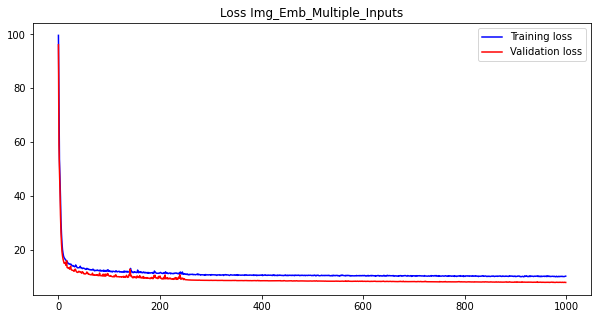

Validation mape:  7.82 %


In [ ]:
encoder = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
                         trainable=False)
size = (240, 240)
emb_size = 1280

images_efficientnet = get_img_emb(df['sell_id'])
images = images_efficientnet

val_nn_img_eff, submission_nn_img_eff = run_img_multi_input()


#### inception_resnet_v2 image embedding
Multiple input:
* inception_resnet_v2 image embedding,
* LaBSE text embedding,
* tabular mlp

Выходные данные были обрезаны до нескольких последних строк (5000).

Epoch 00167: saving model to best_model.hdf5
Epoch 168/1000

Epoch 00168: LearningRateScheduler setting learning rate to 0.009999999776482582.
14/14 [==============================] - 0s 13ms/step - loss: 11.2269 - MAPE: 11.2269 - val_loss: 9.4991 - val_MAPE: 9.4991

Epoch 00168: saving model to best_model.hdf5
Epoch 169/1000

Epoch 00169: LearningRateScheduler setting learning rate to 0.009999999776482582.
14/14 [==============================] - 0s 15ms/step - loss: 11.4388 - MAPE: 11.4388 - val_loss: 9.3735 - val_MAPE: 9.3735

Epoch 00169: saving model to best_model.hdf5
Epoch 170/1000

Epoch 00170: LearningRateScheduler setting learning rate to 0.009999999776482582.
14/14 [==============================] - 0s 14ms/step - loss: 11.1794 - MAPE: 11.1794 - val_loss: 9.5995 - val_MAPE: 9.5995

Epoch 00170: saving model to best_model.hdf5
Epoch 171/1000

Epoch 00171: LearningRateScheduler setting learning rate to 0.0099

<Figure size 720x360 with 0 Axes>

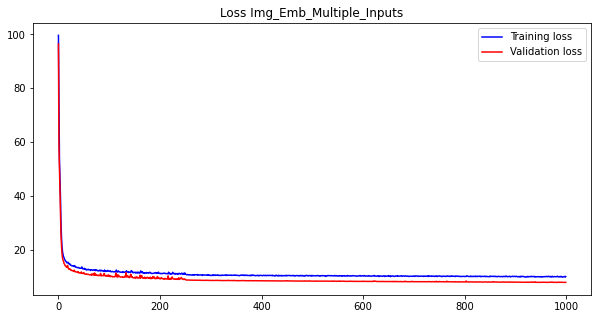

Validation mape:  7.86 %


In [ ]:
encoder = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",
                          trainable=False)
size = (299, 299)
emb_size = 1536

images_resnet = get_img_emb(df['sell_id'])
images = images_resnet

val_nn_img_res, submission_nn_img_res = run_img_multi_input()


Удалось получить снижение MAPE.

### blend predictions

Усредним результаты моделей:
* CatBoostRegressor
* Multiple input:
  * NLP with LaBSE text embedding
  * tabular mlp
* Multiple input:
  * efficientnet_v2 image embedding,
  * LaBSE text embedding,
  * tabular mlp
* Multiple input:
  * inception_resnet_v2 image embedding,
  * LaBSE text embedding,
  * tabular mlp

In [ ]:
def blend_val_array(predicts: list):
    val = sum(predicts) / len(predicts)
    val_mape = mape(y_val, val)*100
    print(f"Validation blended mape: {val_mape: 0.2f} %")
    return val


def blend_submission_array(predicts: list, name=''):
    submission = sample_submission.copy()
    if MAKE_SUBMISSION:
        sub_predict = sum(predicts) / len(predicts)
        submission['price'] = sub_predict
        submission.to_csv(f'blend_submission{name}.csv', index=False)
    return sub_predict


In [ ]:
val = blend_val_array([val_catboost, val_predict_nlp_emb, val_nn_img_eff, val_nn_img_res])
blend = blend_submission_array([submission_catboost, submission_nlp_emb, submission_nn_img_eff, submission_nn_img_res])

Validation blended mape:  7.26 %


Усреднение привело к улучшению качества предсказаний.

## Submit

Усредним результаты моделей:
* CatBoostRegressor
* Multiple input:
  * NLP with LaBSE text embedding
  * tabular mlp
* Multiple input:
  * efficientnet_v2 image embedding,
  * LaBSE text embedding,
  * tabular mlp
* Multiple input:
  * inception_resnet_v2 image embedding,
  * LaBSE text embedding,
  * tabular mlp

используя для тренировки все имеющиеся данные.

In [ ]:
LOG_TARGET = True

(X, y, X_test) = get_split_train_test(df_preproc_catboost)
X_train, X_val, y_train, y_val = X, X, y, y

val_catboost, submission_catboost = run_catboost()

Learning rate set to 0.011035
0:	learn: 0.0422956	test: 0.0422956	best: 0.0422956 (0)	total: 3.89ms	remaining: 1m 17s
1000:	learn: 0.0090157	test: 0.0090157	best: 0.0090157 (1000)	total: 3.53s	remaining: 1m 7s
2000:	learn: 0.0078175	test: 0.0078175	best: 0.0078175 (2000)	total: 7.08s	remaining: 1m 3s
3000:	learn: 0.0072495	test: 0.0072495	best: 0.0072495 (3000)	total: 10.5s	remaining: 59.8s
4000:	learn: 0.0068608	test: 0.0068608	best: 0.0068608 (4000)	total: 14.1s	remaining: 56.3s
5000:	learn: 0.0065467	test: 0.0065467	best: 0.0065467 (5000)	total: 17.5s	remaining: 52.6s
6000:	learn: 0.0062659	test: 0.0062659	best: 0.0062659 (6000)	total: 21s	remaining: 49s
7000:	learn: 0.0060253	test: 0.0060253	best: 0.0060253 (7000)	total: 24.4s	remaining: 45.3s
8000:	learn: 0.0058216	test: 0.0058216	best: 0.0058216 (8000)	total: 27.8s	remaining: 41.7s
9000:	learn: 0.0056400	test: 0.0056400	best: 0.0056400 (9000)	total: 31.2s	remaining: 38.2s
10000:	learn: 0.0054809	test: 0.0054809	best: 0.0054809 (1

Model: "NLP_emb_Multiple_Inputs"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_65_input (InputLayer)     [(None, 669)]        0                                            
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 512)          343040      dense_65_input[0][0]             
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 768)]        0                                            
__________________________________________________________________________________________________
dropout_58 (Dropout)            (None, 512)          0           dense_65[0][0]                   
____________________________________________________________________________

<Figure size 720x360 with 0 Axes>

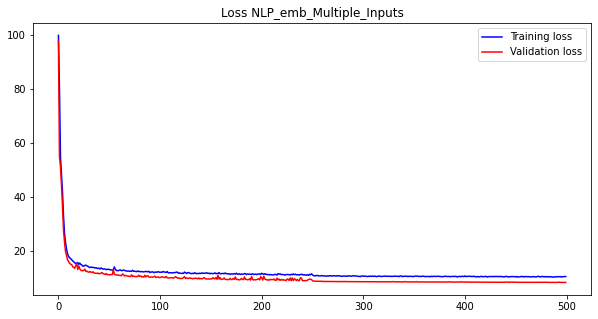

Выходные данные были обрезаны до нескольких последних строк (5000).

Epoch 00167: saving model to best_model.hdf5
Epoch 168/1000

Epoch 00168: LearningRateScheduler setting learning rate to 0.009999999776482582.
14/14 [==============================] - 0s 14ms/step - loss: 11.5325 - MAPE: 11.5325 - val_loss: 9.3555 - val_MAPE: 9.3555

Epoch 00168: saving model to best_model.hdf5
Epoch 169/1000

Epoch 00169: LearningRateScheduler setting learning rate to 0.009999999776482582.
14/14 [==============================] - 0s 14ms/step - loss: 11.4416 - MAPE: 11.4416 - val_loss: 9.6525 - val_MAPE: 9.6525

Epoch 00169: saving model to best_model.hdf5
Epoch 170/1000

Epoch 00170: LearningRateScheduler setting learning rate to 0.009999999776482582.
14/14 [==============================] - 0s 13ms/step - loss: 11.5178 - MAPE: 11.5178 - val_loss: 9.6776 - val_MAPE: 9.6776

Epoch 00170: saving model to best_model.hdf5
Epoch 171/1000

Epoch 00171: LearningRateScheduler setting learning rate to 0.0099

<Figure size 720x360 with 0 Axes>

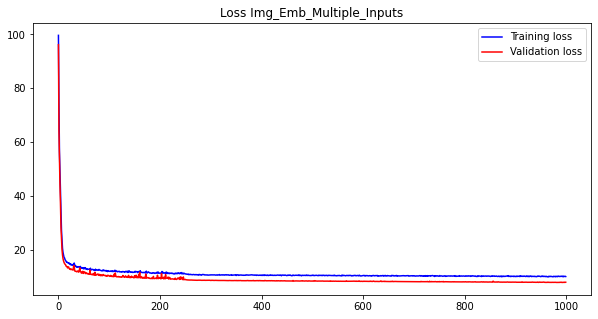

Выходные данные были обрезаны до нескольких последних строк (5000).

Epoch 00167: saving model to best_model.hdf5
Epoch 168/1000

Epoch 00168: LearningRateScheduler setting learning rate to 0.009999999776482582.
14/14 [==============================] - 0s 14ms/step - loss: 11.3323 - MAPE: 11.3323 - val_loss: 9.5173 - val_MAPE: 9.5173

Epoch 00168: saving model to best_model.hdf5
Epoch 169/1000

Epoch 00169: LearningRateScheduler setting learning rate to 0.009999999776482582.
14/14 [==============================] - 0s 15ms/step - loss: 11.2750 - MAPE: 11.2750 - val_loss: 9.8440 - val_MAPE: 9.8440

Epoch 00169: saving model to best_model.hdf5
Epoch 170/1000

Epoch 00170: LearningRateScheduler setting learning rate to 0.009999999776482582.
14/14 [==============================] - 0s 14ms/step - loss: 11.4842 - MAPE: 11.4842 - val_loss: 9.8159 - val_MAPE: 9.8159

Epoch 00170: saving model to best_model.hdf5
Epoch 171/1000

Epoch 00171: LearningRateScheduler setting learning rate to 0.0099

<Figure size 720x360 with 0 Axes>

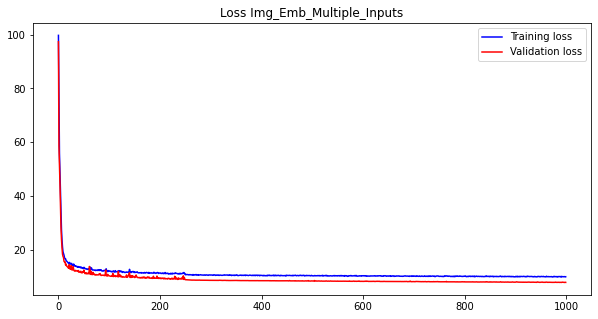

Validation mape:  7.83 %


In [ ]:
LOG_TARGET = False

(X, y, X_test) = get_split_train_test(df_preproc)
X_train, X_val, y_train, y_val = X, X, y, y

val_predict_nlp_emb, submission_nlp_emb = run_LaBSE_emb_multi()

images = images_efficientnet
val_nn_img_eff, submission_nn_img_eff = run_img_multi_input()

images = images_resnet
val_nn_img_res, submission_nn_img_res = run_img_multi_input()


In [ ]:
blend = blend_submission_array([submission_catboost, submission_nlp_emb, submission_nn_img_eff, submission_nn_img_res],
                       name='all')

## Conclusion

- Произведена обработка данных и созданы новые параметры
- Использованы разные архитектуры моделей:
    - градиентный бустинг
    - нейронная сеть на основе табличных данных
    - нейронная сеть на основе:
        - текста
        - табличных данных
    - нейронная сеть на основе:
        - изображений
        - текста
        - табличных данных
- Использован Transfer Learning:
    - `LaBSE` для текста 
    - `efficientnet_v2`, `inception_resnet_v2` для изображений
- Использован `LearningRateScheduler` для коэффициента скорости обучения
- Произведено усреднение полученных предсказаний
- Лучший результат получен при усреднении результатов четырех использованных архитектур моделей.
